# Iris Classification

As a first foray into the world of data science and machine learning, we will explore a simple classification problem: identify flowers (irises, to be exact) by their physical characteristics. The dataset can be found [here](https://archive.ics.uci.edu/ml/datasets/Iris).

So, the very first thing we're going to want to do is download the dataset.

In [279]:
%%bash
for i in iris.data iris.names;
do
    wget -nv -nc https://archive.ics.uci.edu/ml/machine-learning-databases/iris/$i
done

Let's take a peek to see what it looks like:

In [280]:
%%bash
for i in iris.data iris.names;
do
    echo === $i ===
    head $i
    echo
done

=== iris.data ===
5.1,3.5,1.4,0.2,Iris-setosa
4.9,3.0,1.4,0.2,Iris-setosa
4.7,3.2,1.3,0.2,Iris-setosa
4.6,3.1,1.5,0.2,Iris-setosa
5.0,3.6,1.4,0.2,Iris-setosa
5.4,3.9,1.7,0.4,Iris-setosa
4.6,3.4,1.4,0.3,Iris-setosa
5.0,3.4,1.5,0.2,Iris-setosa
4.4,2.9,1.4,0.2,Iris-setosa
4.9,3.1,1.5,0.1,Iris-setosa

=== iris.names ===
1. Title: Iris Plants Database
	Updated Sept 21 by C.Blake - Added discrepency information

2. Sources:
     (a) Creator: R.A. Fisher
     (b) Donor: Michael Marshall (MARSHALL%PLU@io.arc.nasa.gov)
     (c) Date: July, 1988

3. Past Usage:
   - Publications: too many to mention!!!  Here are a few.



So the `iris.names` file contains the description of the dataset, while `iris.data` IS the dataset. I won't reiterate everything in the file, but here are the important points:
* The 5 features in the dataset are 1) sepal length in cm, 2) sepal width in cm, 3) petal length in cm, 4) petal width in cm, 5) class (one of Iris Setosa, Iris Versicolour, Iris Virginica)
* There are 150 feature vectors, with 50 from each class (so the data is balanced)
Let's load the data into pandas so that we can manipulate it.

In [281]:
import pandas as pd
data = pd.read_csv("iris.data", names=["SepLen", "SepWid", "PetLen", "PetWid", "Class"])
data.head()

,SepLen,SepWid,PetLen,PetWid,Class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


Now let's take a look at the data for the different classes using a parallel coordinates plot and some histograms of the features and their correlations.

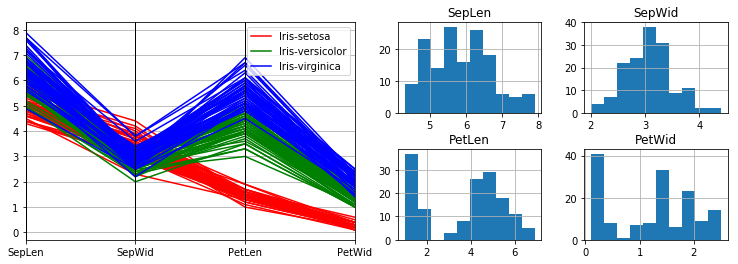

In [282]:
from pandas.plotting import parallel_coordinates, scatter_matrix
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure()
ax = plt.subplot2grid((2,4), (0,0), colspan=2, rowspan=2)
parallel_coordinates(data, class_column="Class", color=('r','g','b'), ax=ax)
for key, coord in zip(data.columns, [(0,2), (0,3), (1,2), (1,3)]):
    ax = plt.subplot2grid((2,4), coord)
    ax.set_title(key)
    data[key].hist(ax=ax)
fig.subplots_adjust(right=1.75, wspace=0.3,hspace=0.4)

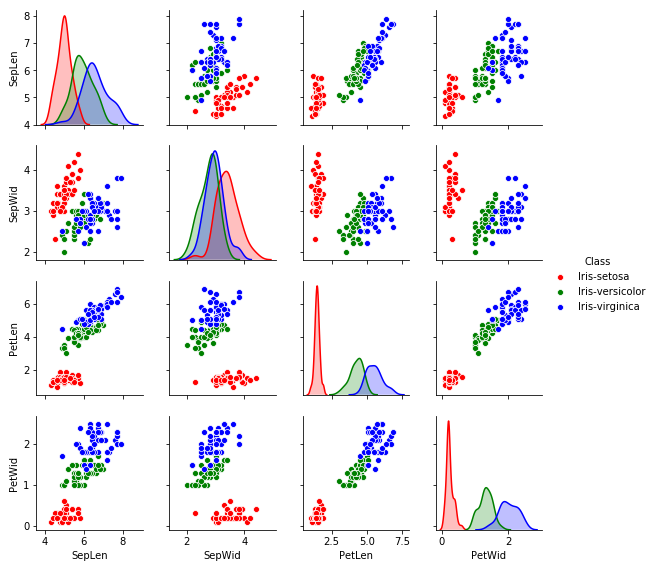

In [283]:
sns.pairplot(data, hue="Class", palette=('r','g','b'), height=2)
plt.show()

We can see some clustering at this point - the Iris-setosa class is readily identifiable by the significantly smaller petal length and width, but the other two classes are have quite a bit of overlap and we'll probably have a tough time separating them. There also seems to be a high degree of correlation between some of the features.

In order to test our classification methods, we'll separate the dataset into training, validation, and test sets after shuffling.

In [455]:
import numpy as np
np.random.seed(123)

# Shuffle the data
data_shuffled = data.sample(frac=1)

# Relabel the classes to something numerical
for i, c in enumerate(["Iris-setosa", "Iris-versicolor", "Iris-virginica"]):
    data_shuffled["Class"] = data_shuffled["Class"].where(data_shuffled["Class"] != c, i)
data_shuffled["Class"] = data_shuffled["Class"].astype(int)

# Split into training/validation/test sets with 60/20/20 split
# Normalize data
i1 = np.around(len(data)*0.60).astype(int)
X_train = np.array(data_shuffled.iloc[:i1,:-1])
mean, std = np.mean(X_train, axis=0), np.std(X_train, axis=0)
X_train = (X_train - mean)/std
y_train = np.array(data_shuffled.iloc[:i1,-1])
i2 = np.around(len(data)*(0.60+0.20)).astype(int)
X_val = (np.array(data_shuffled.iloc[i1:i2,:-1]) - mean)/std
y_val = np.array(data_shuffled.iloc[i1:i2,-1])
X_test = (np.array(data_shuffled.iloc[i2:,:-1]) - mean)/std
y_test = np.array(data_shuffled.iloc[i2:,-1])

Now, as a first step, we'll build a linear classification model using logistic regression.

In [456]:
import sklearn as skl
from sklearn.linear_model import LogisticRegression
model1 = LogisticRegression(penalty='l2', solver='newton-cg', multi_class="multinomial", C=1)
model1.fit(X=X_train, y=y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)

Let's take a look at how we're doing with the training/validation accuracy.

In [457]:
print("Training accuracy: ", model1.score(X_train, y_train))
print("Validation accuracy: ", model1.score(X_val, y_val))

Training accuracy:  0.9666666666666667
Validation accuracy:  0.9666666666666667


Woah; doing pretty well! 100% validation accuracy ain't bad! Guess the data is actually separable. The only hyperparameter we need to tune here is C (the model capacity), and changing it doesn't seem to have any effect whatsoever, so we'll just leave it at the default value of 1.

Let's also try this out with a couple other models, such as SVM and decision trees, to get a good idea of what other options we have.

In [487]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.ensemble import GradientBoostingClassifier

# Define models
models = {1: model1}
models[2] = SVC(C=10, kernel='rbf', gamma=.1) # SVM with radial basis kernel
models[3] = DecisionTreeClassifier(criterion='gini', splitter='best') # Decision tree
models[4] = KNN(n_neighbors=5, algorithm='auto', p=1) # KNN with Manhattan metric
models[5] = GradientBoostingClassifier() # Gradient boosted tree

# Fit models
for m in models:
    models[m].fit(X_train, y_train)

In [488]:
for m in models:
    print("Model {}, validation accuracy: {:.3f}".format(m, models[m].score(X_val, y_val)))
    y_true = y_val
    y_pred = models[m].predict(X_val)
    target_names = ["class 0", "class 1", "class 2"]
    print(skl.metrics.classification_report(y_true, y_pred, target_names=target_names))

Model 1, validation accuracy: 0.967
             precision    recall  f1-score   support

    class 0       1.00      1.00      1.00        11
    class 1       1.00      0.92      0.96        13
    class 2       0.86      1.00      0.92         6

avg / total       0.97      0.97      0.97        30

Model 2, validation accuracy: 0.967
             precision    recall  f1-score   support

    class 0       1.00      1.00      1.00        11
    class 1       1.00      0.92      0.96        13
    class 2       0.86      1.00      0.92         6

avg / total       0.97      0.97      0.97        30

Model 3, validation accuracy: 0.967
             precision    recall  f1-score   support

    class 0       1.00      1.00      1.00        11
    class 1       1.00      0.92      0.96        13
    class 2       0.86      1.00      0.92         6

avg / total       0.97      0.97      0.97        30

Model 4, validation accuracy: 0.967
             precision    recall  f1-score   support

All models seem to be doing fairly well. We can see that there is no trouble at all identifying class 0 (Iris-setosa), but some small issues separating classes 1/2. Full disclosure - the first time I did this analysis I set the numpy seed to 0, which gave me slightly worse results, probably due to the data split. Turns out the random seed is also a hyperparameter that can be tuned!

The held-out test set has similar results:

In [490]:
for m in models:
    print("Model {}, test accuracy: {:.3f}".format(m, models[m].score(X_test, y_test)))
    y_true = y_test
    y_pred = models[m].predict(X_test)
    target_names = ["class 0", "class 1", "class 2"]
    print(skl.metrics.classification_report(y_true, y_pred, target_names=target_names))

Model 1, test accuracy: 0.933
             precision    recall  f1-score   support

    class 0       1.00      1.00      1.00         6
    class 1       0.91      0.91      0.91        11
    class 2       0.92      0.92      0.92        13

avg / total       0.93      0.93      0.93        30

Model 2, test accuracy: 0.967
             precision    recall  f1-score   support

    class 0       1.00      1.00      1.00         6
    class 1       1.00      0.91      0.95        11
    class 2       0.93      1.00      0.96        13

avg / total       0.97      0.97      0.97        30

Model 3, test accuracy: 0.900
             precision    recall  f1-score   support

    class 0       1.00      1.00      1.00         6
    class 1       0.83      0.91      0.87        11
    class 2       0.92      0.85      0.88        13

avg / total       0.90      0.90      0.90        30

Model 4, test accuracy: 0.933
             precision    recall  f1-score   support

    class 0       1.00

Of all the classifiers, it looks like the SVM (model 2) is perhaps the best, with precision, recall, F1, and accuracy scores of 0.97 across the board on both the validation and test set.

So this was a nice, quick little problem. It didn't offer much in the way of difficulty, but that's to be expected, I suppose. We got in a little practice with file manipulation in bash, a number of python libraries (numpy, pandas, matplotlib, seaborn, scikit-learn), and got a very fine result! Future problems will likely be much more difficult!